In [1]:
%%capture --no-stderr
%pip install -U langgraph langchain_community langchain_anthropic langchain_experimental

In [1]:
from utils import *

In [15]:
from langchain_ibm import ChatWatsonx
from ibm_watsonx_ai.foundation_models import ModelInference
from langgraph.prebuilt import create_react_agent
from langchain_core.tools import tool
from langchain_core.messages import HumanMessage


In [3]:
from CreateSpecializedAgent import CreateSpecializedAgent
from langchain_openai import ChatOpenAI
import os

os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY

In [4]:
llm_openai = ChatOpenAI(
    model="gpt-4o"
)

In [23]:
with open('prepocessed_results/restaurants/description.txt', 'r') as file:
    description = file.read()

with open('prepocessed_results/restaurants/json_schema.txt', 'r') as file:
    json_schema = file.read()

restaurants_agent = CreateSpecializedAgent(llm=llm_openai, json_schema=json_schema, collection_description=description, collection_name="restaurants", db_name="hackapizza").agent

prompt_summary = f"Generate a summary of this text: {description}" 
restaurants_summary = llm_openai.invoke([HumanMessage(prompt_summary)]).content

In [24]:
summaries = {
    "restaurants_agent": restaurants_summary
}


In [6]:
from typing import Literal
from typing_extensions import TypedDict

from langchain_anthropic import ChatAnthropic
from langgraph.graph import MessagesState, END
from langgraph.types import Command


members = ["restaurants", "kitchen_codes", "cookbook"]
# Our team supervisor is an LLM node. It just picks the next agent to process
# and decides when the work is completed
options = members + ["FINISH"]

system_prompt = (
    f"""
        descrione alto livello
        descrizione per ogni worker
        processo di interazione
        formato dell'output desiderato
        esempi di ragionamento

        Sei un assistente che deve rispondere a una richiesta dell'utente. 
        Per farlo devi coordinare il lavoro dei seguenti agenti: {members}.
        Ogni agente risponde a domande in linguaggio naturale ed è specializzato
        in un particolare argomento. 
        Qua sotto trovi una descrizione di ciascun agente.
        {summaries}

        Per rispondere alla richiesta dell'utente, devi seguire i seguenti step:
        - sulla base delle descrizioni di ogni agente, suddividi la domanda e contatta appropriatamente gli agenti
        - salvati i risultati di uno o degli agenti 
        - unisci tutti i risultati ottenuti in un'unica risposta
        - se necessario utilizza l'output di un agente per formulare la domanda per un altro agente 


        When finished, respond with FINISH.
    """

    "You are a supervisor tasked with managing a conversation between the"
    f" following workers: {members}. "
    " Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. "
    " When finished, respond with FINISH."
)


class Router(TypedDict):
    """Worker to route to next. If no workers needed, route to FINISH."""

    next: Literal[*options]


llm = ChatWatsonx(
    model_id="meta-llama/llama-3-405b-instruct",
    url = ENDPOINT_URL,
    apikey = API_KEY,
    project_id = PROJECT_ID,
        params = {
            "decoding_method": "greedy",
            "temperature": 0, 
            "min_new_tokens": 5, 
            "max_new_tokens": 2000
        }
)

class State(MessagesState):
    next: str


def supervisor_node(state: State) -> Command[Literal[*members, "__end__"]]:
    messages = [
        {"role": "system", "content": system_prompt},
    ] + state["messages"]
    response = llm.with_structured_output(Router).invoke(messages)
    goto = response["next"]
    if goto == "FINISH":
        goto = END

    return Command(goto=goto, update={"next": goto})

In [7]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import create_react_agent


def restaurant_node(state: State) -> Command[Literal["supervisor"]]:
    result = restaurants_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="restaurants")
            ]
        },
        goto="supervisor",
    )


In [8]:
from typing import Annotated

# from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool

@tool
def translate_query(
    code: Annotated[str, "The query to translate."],
):
    """Use this to translate a query from natural language into mongo db query. 
    """
    return  """ {'queries': ['{ "$unwind": "$menu" }', '{ "$unwind": "$menu.piatti" }', '{ "$match": { "menu.piatti.ingredienti.nomeIngrediente": { "$ne": "basilico" } } }']}"""

@tool
def run_query(
    code: Annotated[str, "The query to execute."],
):
    """Use this to translate a query from natural language into mongo db query. 
    """
    return  """{'_id': ObjectId('678c03f108c1090ce820c6f8'), 'nomeRistorante': 'Trattoria Bella', 'indirizzo': 'Via Roma 123, Torino', 'menu': {'dataMenu': '2025-01-01', 'piatti': {'nomePiatto': 'Risotto alla Milanese', 'ingredienti': [{'nomeIngrediente': 'riso', 'quantita': '150g'}, {'nomeIngrediente': 'zafferano', 'quantita': '1 bustina'}]}}}"""

In [9]:
kitchen_codes_agent = create_react_agent(
    llm, tools=[translate_query, run_query], state_modifier="You have to return a string that is the query translated."
)


def kitchen_codes_node(state: State) -> Command[Literal["supervisor"]]:
    result = kitchen_codes_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="kitchen_codes")
            ]
        },
        goto="supervisor",
    )

In [10]:
cookbook_agent = create_react_agent(
    llm, tools=[translate_query, run_query], state_modifier="You have to return a string that is the query translated."
)

def cookbook_node(state: State) -> Command[Literal["supervisor"]]:
    result = cookbook_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="cookbook")
            ]
        },
        goto="supervisor",
    )


In [11]:
builder = StateGraph(State)
builder.add_edge(START, "supervisor")
builder.add_node("supervisor", supervisor_node)
builder.add_node("restaurants", restaurant_node)
builder.add_node("kitchen_codes", kitchen_codes_node)
builder.add_node("cookbook", cookbook_node)
graph = builder.compile()

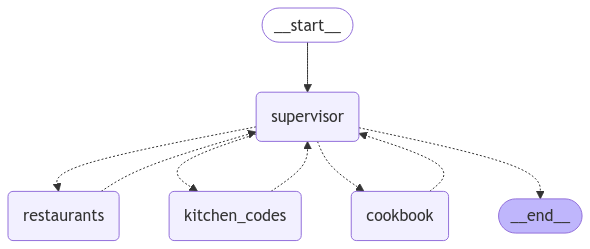

In [12]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

In [13]:
for s in graph.stream(
    {"messages": [("user", "Which plate have riso inside?")]}, subgraphs=True
):
    print(s)
    print("----")

((), {'supervisor': {'next': 'cookbook'}})
----
(('cookbook:9d71c7b2-22c8-c0b4-f68a-595efd75ea5f',), {'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'chatcmpl-tool-0f319b18f29b4e78a4c3d175f75f1124', 'type': 'function', 'function': {'name': 'translate_query', 'arguments': '{"code": "Which plate have riso inside?"}'}}]}, response_metadata={'token_usage': {'completion_tokens': 24, 'prompt_tokens': 308, 'total_tokens': 332}, 'model_name': 'meta-llama/llama-3-405b-instruct', 'system_fingerprint': '', 'finish_reason': 'tool_calls'}, id='chatcmpl-6fe299be6f1a55707865b5d5d4acb9d3', tool_calls=[{'name': 'translate_query', 'args': {'code': 'Which plate have riso inside?'}, 'id': 'chatcmpl-tool-0f319b18f29b4e78a4c3d175f75f1124', 'type': 'tool_call'}], usage_metadata={'input_tokens': 308, 'output_tokens': 24, 'total_tokens': 332})]}})
----
(('cookbook:9d71c7b2-22c8-c0b4-f68a-595efd75ea5f',), {'tools': {'messages': [ToolMessage(content=' {\'queries\': [\'{ "$u

GraphRecursionError: Recursion limit of 25 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/GRAPH_RECURSION_LIMIT